In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
kwargs = {'num_workers': 1, 'pin_memory': True}
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)


cuda


In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 32)
        self.mu = nn.Linear(32, self.latent_dim)
        self.logvar = nn.Linear(32, self.latent_dim)
        # Input size: 28x28
        # conv1 output size: 24x24
        # maxpool1 output size: 12x12
        # conv2 output size: 8x8
        # maxpool2 output size: 4x4

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(self.latent_dim, 32 * 14 * 14)
        self.conv1 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
        # fc output size: 32*14*14
        # Hout = (Hin - 1) * stride - 2 * padding + kernel_size 
        # conv1 output size: (14-1) * 2 - 2 + 4 = 28
        self.conv2 = nn.ConvTranspose2d(16, 1, 3, 1, 1)
        # conv2 output size: (28-1) * 1 - 2 + 3 = 28


    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 32, 14, 14)
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x
        
latent_dim = 2

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder(self.latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
        
# class VAE(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(784, 400)
#         self.fc21 = nn.Linear(400, latent_dim)
#         self.fc22 = nn.Linear(400, latent_dim)
#         self.fc3 = nn.Linear(latent_dim, 400)
#         self.fc4 = nn.Linear(400, 784)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, 784))
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar

In [4]:
class Predictor(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, mu):
        mu = F.relu(self.fc1(mu))
        mu = F.relu(self.fc2(mu))
        mu = self.fc3(mu)
        return mu




# model = CVAE(latent_dim=2).to(device)



# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, gamma=2.0):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + gamma*KLD

def predictor_loss(pred, target):
    # MSE
    return F.mse_loss(pred, target)


In [5]:
model = VAE(latent_dim=2).to(device)
predictor = Predictor(latent_dim=2).to(device)
optimizer = optim.AdamW(list(model.parameters()) + list(predictor.parameters()), lr=1e-3)

In [10]:
epochs = 10
log_interval = 10
batch_size = 128

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device).to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_vae = loss_function(recon_batch, data, mu, logvar)
        loss_predictor = predictor_loss(predictor(mu), label)
        loss = loss_vae + 20*loss_predictor
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')

C:\Users\liamt\AppData\Local\Temp\ipykernel_26016\475529668.py:35: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, target)


Train Epoch: 1 [0/60000 (0%)]	Loss: 617.675964
Train Epoch: 1 [1280/60000 (2%)]	Loss: 366.059753
Train Epoch: 1 [2560/60000 (4%)]	Loss: 360.034302
Train Epoch: 1 [3840/60000 (6%)]	Loss: 333.712677
Train Epoch: 1 [5120/60000 (9%)]	Loss: 324.166718
Train Epoch: 1 [6400/60000 (11%)]	Loss: 326.012787
Train Epoch: 1 [7680/60000 (13%)]	Loss: 302.376862
Train Epoch: 1 [8960/60000 (15%)]	Loss: 300.149170
Train Epoch: 1 [10240/60000 (17%)]	Loss: 283.637085
Train Epoch: 1 [11520/60000 (19%)]	Loss: 282.022797
Train Epoch: 1 [12800/60000 (21%)]	Loss: 274.366455
Train Epoch: 1 [14080/60000 (23%)]	Loss: 242.107452
Train Epoch: 1 [15360/60000 (26%)]	Loss: 238.850632
Train Epoch: 1 [16640/60000 (28%)]	Loss: 230.495392
Train Epoch: 1 [17920/60000 (30%)]	Loss: 222.434891
Train Epoch: 1 [19200/60000 (32%)]	Loss: 211.968643
Train Epoch: 1 [20480/60000 (34%)]	Loss: 220.356308
Train Epoch: 1 [21760/60000 (36%)]	Loss: 227.321564
Train Epoch: 1 [23040/60000 (38%)]	Loss: 213.179337
Train Epoch: 1 [24320/60000 

C:\Users\liamt\AppData\Local\Temp\ipykernel_26016\475529668.py:35: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, target)


====> Epoch: 1 Average loss: 231.3350
====> Test set loss: 182.9436
Train Epoch: 2 [0/60000 (0%)]	Loss: 182.882919
Train Epoch: 2 [1280/60000 (2%)]	Loss: 180.290817
Train Epoch: 2 [2560/60000 (4%)]	Loss: 184.832687
Train Epoch: 2 [3840/60000 (6%)]	Loss: 186.855164
Train Epoch: 2 [5120/60000 (9%)]	Loss: 186.603058
Train Epoch: 2 [6400/60000 (11%)]	Loss: 184.804550
Train Epoch: 2 [7680/60000 (13%)]	Loss: 183.331573
Train Epoch: 2 [8960/60000 (15%)]	Loss: 174.998047
Train Epoch: 2 [10240/60000 (17%)]	Loss: 180.342728
Train Epoch: 2 [11520/60000 (19%)]	Loss: 179.052475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 171.134811
Train Epoch: 2 [14080/60000 (23%)]	Loss: 176.300034
Train Epoch: 2 [15360/60000 (26%)]	Loss: 179.233917
Train Epoch: 2 [16640/60000 (28%)]	Loss: 181.577164
Train Epoch: 2 [17920/60000 (30%)]	Loss: 186.183563
Train Epoch: 2 [19200/60000 (32%)]	Loss: 176.812988
Train Epoch: 2 [20480/60000 (34%)]	Loss: 184.190582
Train Epoch: 2 [21760/60000 (36%)]	Loss: 178.881470
Train Epoch:

In [11]:
# torch.save(model.state_dict(), 'results/vae_with_predictor.pth')

In [12]:
vae_with_predictor = model

In [13]:
model = VAE(latent_dim).to(device)
optimizer = optim.AdamW(list(model.parameters()), lr=1e-3)

In [14]:
epochs = 10
log_interval = 10
batch_size = 128

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device).to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_vae = loss_function(recon_batch, data, mu, logvar)
        loss = loss_vae
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/no_predictor_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/no_predictor_sample' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 570.873962
Train Epoch: 1 [1280/60000 (2%)]	Loss: 367.440765
Train Epoch: 1 [2560/60000 (4%)]	Loss: 337.104767
Train Epoch: 1 [3840/60000 (6%)]	Loss: 319.690704
Train Epoch: 1 [5120/60000 (9%)]	Loss: 298.315430
Train Epoch: 1 [6400/60000 (11%)]	Loss: 299.251465
Train Epoch: 1 [7680/60000 (13%)]	Loss: 293.772156
Train Epoch: 1 [8960/60000 (15%)]	Loss: 275.536438
Train Epoch: 1 [10240/60000 (17%)]	Loss: 281.324921
Train Epoch: 1 [11520/60000 (19%)]	Loss: 263.788971
Train Epoch: 1 [12800/60000 (21%)]	Loss: 243.475967
Train Epoch: 1 [14080/60000 (23%)]	Loss: 229.173096
Train Epoch: 1 [15360/60000 (26%)]	Loss: 226.622650
Train Epoch: 1 [16640/60000 (28%)]	Loss: 217.344177
Train Epoch: 1 [17920/60000 (30%)]	Loss: 209.526520
Train Epoch: 1 [19200/60000 (32%)]	Loss: 215.421341
Train Epoch: 1 [20480/60000 (34%)]	Loss: 209.898331
Train Epoch: 1 [21760/60000 (36%)]	Loss: 210.282654
Train Epoch: 1 [23040/60000 (38%)]	Loss: 207.495575
Train Epoch: 1 [24320/60000 

In [15]:
def get_latents(model):
    y_test = []
    latent_test = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            latent_test += mu.cpu().numpy().tolist()
            y_test += label.cpu().numpy().tolist()
    return np.array(latent_test), np.array(y_test)

In [16]:
vae_no_predictor = model

In [17]:
# torch.save(vae_no_predictor.state_dict(), 'results/vae_no_predictor.pth')

In [18]:
import matplotlib.pyplot as plt
import numpy as np

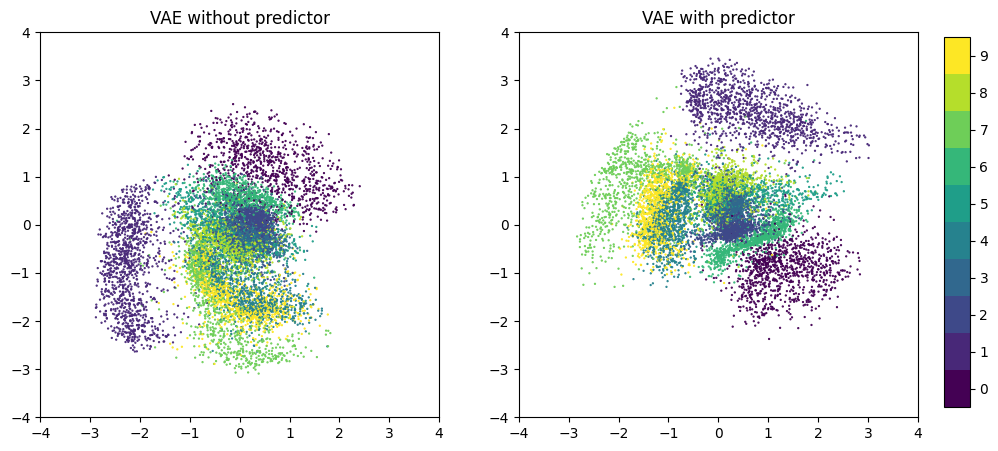

In [19]:
fig = plt.figure(figsize=(13, 5))
cmap = plt.get_cmap('viridis', 10)
ts = [vae_no_predictor, vae_with_predictor]
titles = ['VAE without predictor', 'VAE with predictor']
for i, t in enumerate(ts):
    plt.subplot(1, 2, i+1)
    latent_test, y_test = get_latents(t)
    im = plt.scatter(latent_test[:,0], latent_test[:,1], c=y_test, cmap=cmap, marker='o', s=0.4,  vmin=-0.5, vmax=9.5, )
    plt.title(titles[i])
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
fig.subplots_adjust(right=0.8)
fig.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10));